In [1]:
import json
from tqdm.notebook import tqdm
import os

## Загрузка датасета

In [2]:
with open('sentiment-analysis-in-russian/dataset.json', 'r') as f:
    data = json.load(f)

len(data)

10319

## Предобработка текстов 

In [3]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

In [4]:
prep_data = []
for record in tqdm(data):
    if 'sentiment' not in record:
        continue
    
    prep_tokens = []
    for word in record['text'].split():
        cleaned_word  = ''
        for ch in word.lower():
            if ch in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя-':
                cleaned_word += ch
            elif ch == '!':
                prep_tokens += ['!']
        if cleaned_word != '':
            prep_tokens += [morph.parse(cleaned_word)[0].normal_form]

    prep_record = {
        'sentiment': record['sentiment'],
        'text': ' '.join(prep_tokens)
    }
    prep_data += [prep_record]

  0%|          | 0/10319 [00:00<?, ?it/s]

In [5]:
prep_data[0]

{'sentiment': 'negative',
 'text': 'досудебный расследование по факт покупка енпф пакет облигация тоо бузгул аурум быть начать по инициатива национальный банк рк сообщить директор департамент защита право потребитель и финансовый услуга нацбанк казахстан александр терентьев основание для досудебный расследование стать обращение национальный банк письмо от ноябрь год быть обращение национальный банк в правоохранительный орган мы этот сделка показаться сомнительный недостаточно корректный поэтому нацбанк ноябрь год обратиться в правоохранительный орган это то что я мочь озвучить на сегодня идти следствие проводиться проверка сказать терентьев декабрь в нацбанк заявить что не знать что стать основание для проверка енпф декабрь факт проведение проверка в ао единый накопительный пенсионный фонд подтвердиться пресс-служба национальный банк сообщить что проверка проводить по операция совершить ао енпф в отношение инвестирование собственный актив также в финрегулятор сообщать что по сделка енп

In [6]:
len(prep_data)

8263

## Анализ экспрессивов и регрессионная модель

In [7]:
negative_set = []
neutral_set = []
positive_set = []

for record in prep_data:
    if record['sentiment'] == 'negative':
        negative_set += [record['text']]
    elif record['sentiment'] == 'neutral':
        neutral_set += [record['text']]
    else:
        positive_set += [record['text']]
len(negative_set), len(neutral_set), len(positive_set)

(1434, 4034, 2795)

In [14]:
import numpy as np

WORD = 'сожаление'

logodds = []
for subset in [negative_set, neutral_set, positive_set]:
    word_freq = 0
    for text in subset:
        for word in text.split():
            if WORD == word:
                word_freq += 1
    
    subset_len = 0
    for text in subset:
        subset_len += len(text)

    logodds += [np.log(word_freq / (subset_len - word_freq))]
word_freq

67

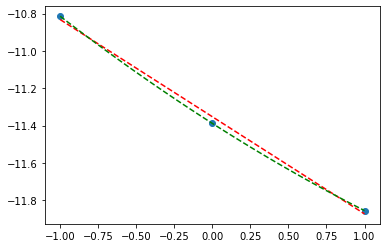

In [15]:
import matplotlib.pyplot as plt

sentiment = [-1, 0, 1]

k, b = np.polyfit(sentiment, logodds, 1)
y_reg_lin = []
for x in sentiment:
    y_reg_lin += [k * x + b]

a, b, c = np.polyfit(sentiment, logodds, 2)

parabolic_x = np.linspace(-1, 1)
y_reg_parabolic = []
for x in parabolic_x:
    y_reg_parabolic += [a * x ** 2 + b * x + c]

plt.scatter(sentiment, logodds)
plt.plot(sentiment, y_reg_lin, 'r--')
plt.plot(parabolic_x, y_reg_parabolic, 'g--')
plt.show()